In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
import geopandas as gpd
%matplotlib inline

In [2]:
#HANDLE THE CRIME DATA CSV FILE

In [3]:
df = pd.read_csv('actes-criminels.csv')
df.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122
3,Méfait,2017-07-21,jour,21.0,NaN,NaN,NaN,NaN
4,Méfait,2017-07-29,jour,12.0,NaN,NaN,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 247781 entries, 0 to 247780
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   CATEGORIE  247781 non-null  object 
 1   DATE       247781 non-null  object 
 2   QUART      247781 non-null  object 
 3   PDQ        247776 non-null  float64
 4   X          205753 non-null  float64
 5   Y          205753 non-null  float64
 6   LONGITUDE  205753 non-null  float64
 7   LATITUDE   205753 non-null  float64
dtypes: float64(5), object(3)
memory usage: 15.1+ MB


In [5]:
df['CATEGORIE'].value_counts()

CATEGORIE
Vol dans / sur véhicule à moteur    73160
Introduction                        61668
Méfait                              54323
Vol de véhicule à moteur            44244
Vols qualifiés                      14156
Infractions entrainant la mort        230
Name: count, dtype: int64

In [6]:
#drop any NaN PDQ rows because our model will take that as input
#Limitations: we lost some crime category data
df = df.dropna(subset=['PDQ'])
df['CATEGORIE'].value_counts()

CATEGORIE
Vol dans / sur véhicule à moteur    73158
Introduction                        61666
Méfait                              54323
Vol de véhicule à moteur            44243
Vols qualifiés                      14156
Infractions entrainant la mort        230
Name: count, dtype: int64

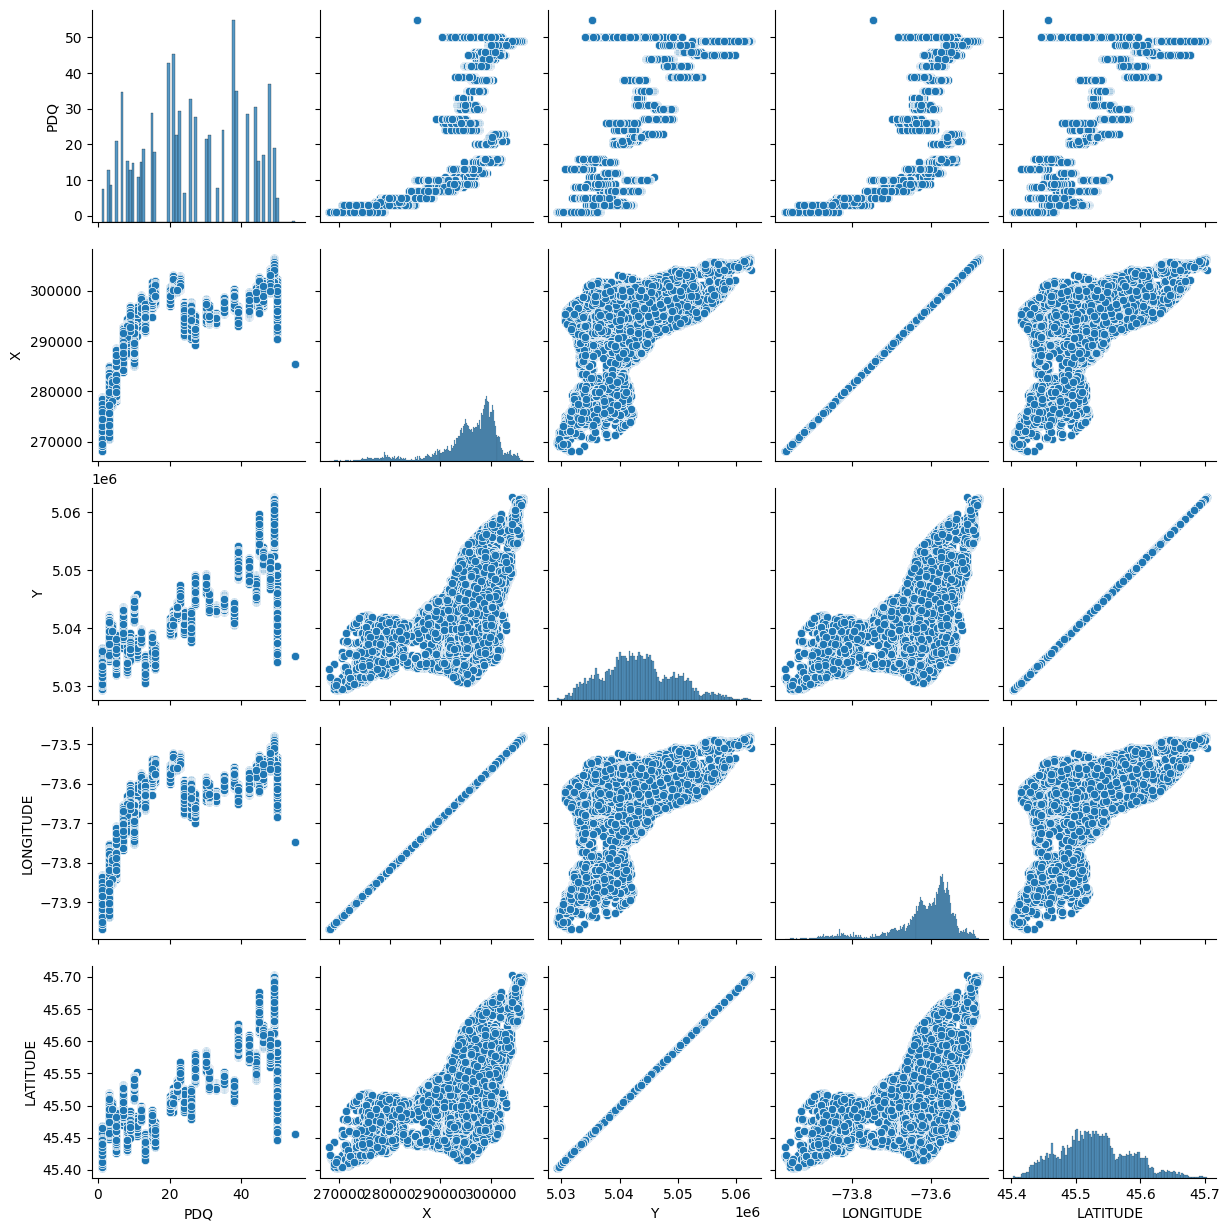

In [7]:
#visualize correlations
sns.pairplot(df)

In [7]:
#we want a multiclass regression, so we labeled
#each of the categories in a new target column
encoder = LabelEncoder()
df['target'] = encoder.fit_transform(df['CATEGORIE'])
#making sure the numbers match up
print(df['CATEGORIE'].value_counts())
print(df['target'].value_counts())

CATEGORIE
Vol dans / sur véhicule à moteur    73158
Introduction                        61666
Méfait                              54323
Vol de véhicule à moteur            44243
Vols qualifiés                      14156
Infractions entrainant la mort        230
Name: count, dtype: int64
target
3    73158
1    61666
2    54323
4    44243
5    14156
0      230
Name: count, dtype: int64


In [8]:
#based on the counts, we can build a dict to store which label
#corresponds to which category
target_dict = {0:'Infractions entrainant la mort', 1:'Introduction', 2:'Méfait', 3:'Vol dans / sur véhicule à moteur', 4:'Vol de véhicule à moteur', 5:'Vols qualifiés'}

In [9]:
#HANDLE LOCATION DATA GEOJSON FILE

In [10]:
gf = gpd.read_file('limitespdq.geojson')
gf.head()

,PDQ,NOM_PDQ,geometry
0,1,PDQ-1,"MULTIPOLYGON (((-73.84050 45.45690, -73.84220 ..."
1,3,PDQ-3,"MULTIPOLYGON (((-73.93970 45.47010, -73.93980 ..."
2,4,PDQ-4,"MULTIPOLYGON (((-73.81590 45.50260, -73.81580 ..."
3,5,PDQ-5,"MULTIPOLYGON (((-73.72280 45.43200, -73.72270 ..."
4,7,PDQ-7,"MULTIPOLYGON (((-73.67240 45.53250, -73.67150 ..."


In [11]:
gf.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   PDQ       29 non-null     int64   
 1   NOM_PDQ   29 non-null     object  
 2   geometry  29 non-null     geometry
dtypes: geometry(1), int64(1), object(1)
memory usage: 824.0+ bytes


In [12]:
#use the bounds property to get the longitude, latitude ranges each PDQ covers
gf['geometry'].bounds[:5]

,minx,miny,maxx,maxy
0,-73.9923,45.4012,-73.8314,45.4706
1,-73.9477,45.4422,-73.7530,45.5210
2,-73.8570,45.4628,-73.7682,45.5061
3,-73.8466,45.4249,-73.7079,45.4937
4,-73.7739,45.4606,-73.6509,45.5325


In [24]:
#TRAINING THE MODEL
df.head()

,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE,target
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,4
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,4
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,4
3,Méfait,2017-07-21,jour,21.0,NaN,NaN,NaN,NaN,2
4,Méfait,2017-07-29,jour,12.0,NaN,NaN,NaN,NaN,2


In [14]:
#Using a random forest classifer for our model that will
#predict the relative liklihood of each type of crime happening given a location
X_train, X_test, y_train, y_test = train_test_split(df[['PDQ']], df['target'], test_size = 0.2)
model = RandomForestClassifier(n_estimators=40)
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.33140285737347647

In [15]:
#IMPORTANT: As you can see, our model's score is pretty low.
#Due to the lack of time, we were not able to opitmize its performance.
#However, note that we are doing a relative ranking of the crimes, from likeliest to least likeliest.
#So this is not invalidate our model, for we are comparing the class probabilites to each other.

In [16]:
#THE PROGRAM USING NOMINATIM GEO API
#1. USER INPUTS AN ADDRESS
#2. THE ADDRESS IS CONVERTED TO LONG/LAT COORDINATES
#3. USING THE GEOJSON FILE, FIND THE PDQ THAT THE COORDINATED FALL IN
#4. THE PDQ WILL GO INTO OUR MODEL, AND A RANKING OF THE TYPE OF CRIMES WILL BE PRINTED
#(FROM MOST LIKELY TO LEAST LIKELY)

In [20]:
import json
import urllib.parse
import urllib.request

In [21]:
NOMINATIM_BASE = 'https://nominatim.openstreetmap.org'
REFERER = 'azraz'

def _geocoding_url(address):
    '''
    Return the appropriate url to request geocoding information from Nominatim API.
    '''
    query_params = [
        ('q', address),
        ('format', 'json')
        ]

    encoded_params = urllib.parse.urlencode(query_params)
    
    url = f'{NOMINATIM_BASE}/search?{encoded_params}'
    return url

def _download_geocoding(url):
    '''
    Send the a request to the search Nominatim API to get back a json response.
    Return the list of dictionary.
    Handle any errors that may arise in the process.
    '''
    response = None

    try:
        request = urllib.request.Request(url, headers = {'Referer': REFERER})
        response = urllib.request.urlopen(request)
        response_json = response.read().decode(encoding = 'utf-8')
        return json.loads(response_json)
    
    finally:
        if response != None:
            response.close()
            
def _get_center_coordinates():
    '''
    Get the lat,lon of the center from Nominatim's response.
    Handle error that may occur.
    '''
    address = input()
    url = _geocoding_url(address)
    data = _download_geocoding(url)

    center_lat = data[0]['lat']
    center_long = data[0]['lon']

    return float(center_lat), float(center_long)

def _translate_french(word):
    if word == 'Introduction':
        return 'Break in'
    if word == 'Vol dans / sur véhicule à moteur':
        return 'Theft in/on motor vehicle'
    if word == 'Méfait':
        return 'Mischief'
    if word == 'Vol de véhicule à moteur':
        return 'Motor vehicle theft'
    if word == 'Vols qualifiés':
        return 'Robbery'
    if word == 'Infractions entrainant la mort':
        return 'Offenses resulting in death'

In [22]:
def crime_ranks():
    '''
    Print the ranking of each type of crime, from highest threat to lowest.
    '''
    y_coor, x_coor = _get_center_coordinates()
    target_row = gf.loc[((gf['geometry'].bounds['minx'] <= x_coor) & (gf['geometry'].bounds['maxx'] >= x_coor) & (gf['geometry'].bounds['miny'] <= y_coor) & (gf['geometry'].bounds['maxy'] <= y_coor))]
    target_pdq = target_row['PDQ'].to_frame()
    
    ranks = model.predict_proba(target_pdq)
    l1 = list(enumerate(ranks[0]))
    ranked = sorted(l1, key = lambda x: x[1], reverse = True)
    
    for i in range(len(ranked)):
        category = target_dict[ranked[i][0]]
        print(f'Threat #{i+1}: {_translate_french(category)}')

In [23]:
crime_ranks()

300 Rue Bridge, Montreal, QC, Canada
Threat #1: Break in
Threat #2: Theft in/on motor vehicle
Threat #3: Mischief
Threat #4: Motor vehicle theft
Threat #5: Robbery
Threat #6: Offenses resulting in death


In [31]:
crime_ranks()

7070 Henri Julien Ave, Montreal, Quebec H2S 3S3, Canada
Threat #1: Theft in/on motor vehicle
Threat #2: Break in
Threat #3: Mischief
Threat #4: Motor vehicle theft
Threat #5: Robbery
Threat #6: Offenses resulting in death


In [ ]:
#END OF DATATHON

In [ ]:
#Demo
# Costco: 300 Rue Bridge, Montreal, QC, Canada
# Jean Talon Market: 7070 Henri Julien Ave, Montreal, Quebec H2S 3S3, Canada